In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Train the ML model
from utils import sample_files, load_encoder_data, plot_loss, plot_multi_loss
from utils import fast_tensor_load, get_model_size

from models import FeatureExtractor, AutoEncoderTranspose, AutoEncoderEfficientNet

import time
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

2023-11-24 10:27:30.900729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 10:27:31.138303: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-24 10:27:31.174962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-11-24 10:27:31

In [3]:
IMG_OUTPUT_SIZE = 128
DATA_LOAD_METHOD='FAST_TENSOR' # it can be TENSOR or DATASET or FAST_TENSOR

num_Turns_Case = 1
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# Initialize parameters
data_dir = './tomo_data/datasets_encoder_TF_08-11-23'

# data_dir = './tomo_data/datasets'
timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
print('Using timestamp: ', timestamp)


Using timestamp:  2023_11_24_10-27-37


In [4]:
# Train specific
train_cfg = {
    'dataset%': 0.5,
    'normalization': 'minmax',
    'img_normalize': 'off',
    'batch_size': 128
}

autoenc_cfg = {
    'epochs': 50,
    'filters': [8, 16, 32],
    'dense_layers': [512, 16],
    'decoder_dense_layers': [512],
    'cropping': [14, 14],
    'kernel_size': 3,
    'strides': [2, 2],
    'activation': 'relu',
    'conv_padding': 'same',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.0,
    'loss': 'mae',
    'lr': 1e-3,
    'use_bias': False,
    'normalization': 'minmax',
    'img_normalize': 'off',
    'conv_batchnorm': False,
    'dense_batchnorm': False,
}

feature_extractor_cfg = {
    'epochs': 50,
    'dense_layers': [256, 32],
    'activation': 'relu',
    'dropout': 0.0,
    'loss': 'mae',
    'lr': 1e-3,
    'use_bias': True,
    'batchnorm': False,
}

In [5]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
device_to_use = 0

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[device_to_use], True)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[device_to_use],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(
            logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using the CPU')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


No GPU available, using the CPU


2023-11-24 10:27:46.863409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-11-24 10:27:46.863610: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-24 10:27:46.863632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist


In [6]:
np.random.seed(42)

start_t = time.time()

assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'

TRAINING_PATH = os.path.join(ML_dir, 'training-??.npz')
VALIDATION_PATH = os.path.join(ML_dir, 'validation-??.npz')

x_train, y_train = fast_tensor_load(TRAINING_PATH, train_cfg['dataset%'])
print('Number of Training files: ', len(y_train))

x_valid, y_valid = fast_tensor_load(
    VALIDATION_PATH, train_cfg['dataset%'])
print('Number of Validation files: ', len(y_valid))

end_t = time.time()
print(
    f'\n---- Input files have been read, elapsed: {end_t - start_t} ----\n')

Loading ./tomo_data/datasets_encoder_TF_08-11-23/ML_data/training-00.npz


2023-11-24 10:28:00.893401: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Training files:  7942
Loading ./tomo_data/datasets_encoder_TF_08-11-23/ML_data/validation-00.npz
Number of Validation files:  701

---- Input files have been read, elapsed: 12.731863021850586 ----



In [10]:
from models import AutoEncoderEfficientNet
# Model instantiation
start_t = time.time()

autoenc_cfg = {
    'epochs': 50,
    'filters': [8, 16, 32],
    'dense_layers': [256],
    'reshape_shape': (13, 13, 1),
    'dense_batchnorm': False,
    'cropping': [12, 12],
    'kernel_size': 3,
    'strides': [2, 2],
    'activation': 'relu',
    'conv_padding': 'same',
    'loss': 'mae',
    'lr': 1e-3,
    'use_bias': False,
    'normalization': 'minmax',
    'img_normalize': 'off',
    'conv_batchnorm': False,
    'dense_batchnorm': False,
}

autoenc = AutoEncoderEfficientNet(input_shape=x_train.shape[1:], **autoenc_cfg)
encoder = autoenc.encoder
latent_dim = encoder.output_shape[1]
print(autoenc.model.summary())
# print(encoder.summary())
print(
    f'\n---- Models initialized, size: {get_model_size(autoenc.model):.1f}MB elapsed: {time.time() - start_t} ----\n')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 Crop (Cropping2D)           (None, 104, 104, 1)       0         
                                                                 
 sequential_3 (Sequential)   (None, 1408)              8768798   
                                                                 
 Flatten (Flatten)           (None, 1408)              0         
                                                                 
 encoder_dense_1 (Dense)     (None, 256)               360704    
                                                                 
 encoder_dense_final (Dense)  (None, 169)              43433     
                                                                 
 LatentSpace (Lambda)        (None, 169)               

In [ ]:
# Model instantiation
start_t = time.time()

autoenc = AutoEncoderTranspose(input_shape=x_train.shape[1:], **autoenc_cfg)
encoder = autoenc.encoder
latent_dim = encoder.output_shape[1]
print(autoenc.model.summary())
print(encoder.summary())
print(
    f'\n---- Models initialized, size: {get_model_size(autoenc.model):.1f}MB elapsed: {time.time() - start_t} ----\n')

In [11]:
# tf.config.run_functions_eagerly(True)
# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'autoenc-transpose.h5'),
                                            monitor='val_loss', save_best_only=True)

start_time = time.time()

history = autoenc.model.fit(
    x=x_train, y=x_train, 
    validation_data=(x_valid, x_valid),
    # x=y_train, y=x_train, 
    # validation_data=(y_valid, x_valid),
    epochs=autoenc_cfg['epochs'],
    callbacks=[stop_early], 
    batch_size=train_cfg['batch_size'],
    verbose=1)

total_time = time.time() - start_time
print(
        f'\n---- Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')

Epoch 1/50
63/63 [==============================] - 133s 2s/step - loss: 0.0033 - val_loss: 0.0025
Epoch 2/50
63/63 [==============================] - 112s 2s/step - loss: 0.0018 - val_loss: 0.0016
Epoch 3/50
63/63 [==============================] - 112s 2s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/50
63/63 [==============================] - 113s 2s/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5/50
 6/63 [=>............................] - ETA: 1:41 - loss: 0.0016

KeyboardInterrupt: 

In [72]:
## load autoencoder
# trial_dir = os.path.join('./trials/', '2023_11_13_11-52-53')
# weights_dir = os.path.join(trial_dir, 'weights')
# plots_dir = os.path.join(trial_dir, 'plots')
# autoenc = keras.models.load_model(os.path.join(weights_dir, f'autoenc_dense_512_16.h5'))
## Extract only the encoder part
# encoder = keras.Model(inputs=autoenc.inputs,
#                       outputs=autoenc.get_layer('LatentSpace').output)

(array([7346.,  630., 1054., 1233., 1059.,  956.,  872.,  856.,  775.,
         802.,  768.,  705.,  733.,  715.,  581.,  528.,  520.,  434.,
         393.,  367.,  299.,  287.,  229.,  214.,  187.,  171.,  157.,
         110.,  103.,   81.,   59.,   53.,   47.,   40.,   34.,   29.,
          47.,   22.,   37.,   24.,   33.,   32.,   31.,   27.,   23.,
          40.,   31.,   29.,   21.,   27.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18000001,
        0.2       , 0.22      , 0.23999999, 0.25999999, 0.28      ,
        0.30000001, 0.31999999, 0.34      , 0.36000001, 0.38      ,
        0.40000001, 0.41999999, 0.44      , 0.46000001, 0.47999999,
        0.5       , 0.51999998, 0.54000002, 0.56      , 0.57999998,
        0.60000002, 0.62      , 0.63999999, 0.66000003, 0.68000001,
        0.69999999, 0.72000003, 0.74000001, 0.75999999, 0.77999997,
        0.80000001, 0.81999999, 0.83999997, 0.86000001, 

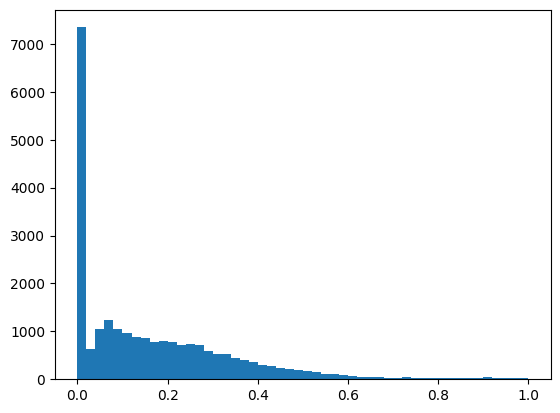

In [181]:
plt.figure()
plt.hist(y_latent_valid.numpy().flatten(), bins=50)

plt.figure()
bxplots = plt.boxplot(y_latent_valid.numpy())
plt.xticks(rotation=90)

In [13]:
# Encode the train samples to get the latent space
x_latent_train = encoder.predict(x_train)
x_latent_valid = encoder.predict(x_valid)

22/22 [==============================] - 0s 3ms/step


In [19]:
model_cfg = {}
models = {}
for var_name in var_names:
    i = var_names.index(var_name)
    print(f'\n---- Initializing model: {var_name} ----\n')
    
    # cfg = train_cfg.copy()
    # cfg.update(model_cfg.get(var_name, {}))
    model_cfg[var_name] = feature_extractor_cfg.copy()
    model = FeatureExtractor(input_shape=latent_dim,
                             output_features=1,
                             output_name=var_name, **model_cfg[var_name])

    # print(model.model.summary())

    if 'TENSOR' in DATA_LOAD_METHOD:
        models[var_name] = {'model': model.model,
                            'train': tf.gather(y_train, i, axis=1),
                            'valid': tf.gather(y_valid, i, axis=1)}

    elif DATA_LOAD_METHOD=='DATASET':
        # method not supported
        pass

print(
    f'\n---- Models initialized, size: {get_model_size(model.model):.2f}MB, elapsed: {time.time() - start_t} ----\n')

historyMulti = {}
for var_name in models:
    model = models[var_name]['model']

    # Train the encoder
    print(f'\n---- {var_name}: Training the encoder ----\n')

    start_time = time.time()

    # callbacks, save the best model, and early stop if no improvement in val_loss
    stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5, restore_best_weights=True)
    save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder_{var_name}.h5'),
                                                monitor='val_loss', save_best_only=True)
    if 'TENSOR' in DATA_LOAD_METHOD:
        history = model.fit(
            x=x_latent_train, y=models[var_name]['train'], 
            epochs=model_cfg[var_name]['epochs'],
            validation_data=(x_latent_valid, models[var_name]['valid']),
            callbacks=[save_best], 
            batch_size=train_cfg['batch_size'],
            verbose=0)
    elif DATA_LOAD_METHOD=='DATASET':
        # method not supported
        pass
    historyMulti[f'{var_name}_loss'] = history.history['loss']
    historyMulti[f'{var_name}_val_loss'] = history.history['val_loss']
    
    total_time = time.time() - start_time
    print(
        f'\n---- {var_name}: Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')


---- Initializing model: phEr ----


---- Initializing model: enEr ----


---- Initializing model: bl ----


---- Initializing model: inten ----


---- Initializing model: Vrf ----


---- Initializing model: mu ----


---- Initializing model: VrfSPS ----


---- Models initialized, size: 0.05MB, elapsed: 377.1579051017761 ----


---- phEr: Training the encoder ----


---- phEr: Training complete, epochs: 50, min loss 0.00636272132396698, total time 4.161031246185303 ----


---- enEr: Training the encoder ----


---- enEr: Training complete, epochs: 50, min loss 0.0077285426668822765, total time 4.25234842300415 ----


---- bl: Training the encoder ----


---- bl: Training complete, epochs: 50, min loss 0.04381466656923294, total time 4.473048448562622 ----


---- inten: Training the encoder ----


---- inten: Training complete, epochs: 50, min loss 0.24416381120681763, total time 4.0272369384765625 ----


---- Vrf: Training the encoder ----


---- Vrf: Training complete, epochs: 50, mi


---- Plotting loss ----

[0.24882041 0.16222306 0.13963287 0.12726406 0.11747016 0.11124703
 0.10696295 0.10310054 0.1002085  0.09708977 0.09534935 0.09191721
 0.09099983 0.08878878 0.08648456 0.08501771 0.08427337 0.08264487
 0.08147671 0.08105639 0.07978497 0.07885192 0.07874292 0.0782806
 0.07680031 0.07514101 0.07469272 0.07461906 0.0734559  0.07315127
 0.07271031 0.07154317 0.07179766 0.0720548  0.07179695 0.07039974
 0.07083493 0.06955649 0.06920534 0.07072217 0.06877874 0.0691145
 0.06851017 0.06819439 0.06755308 0.06766859 0.0682935  0.06676308
 0.06614726 0.06773187]
[0.18042699 0.14499642 0.13071265 0.12082828 0.11458543 0.10559533
 0.10571702 0.10166779 0.09717193 0.10140573 0.09319863 0.09456405
 0.09111042 0.08713555 0.08499096 0.08786436 0.08271011 0.08468715
 0.08606103 0.0801104  0.08021638 0.08268087 0.08313242 0.0780836
 0.07621484 0.07754204 0.07657186 0.07741291 0.07773212 0.07739024
 0.07729428 0.07429474 0.07944974 0.07739882 0.07619749 0.07424362
 0.07190385 0.0

IndexError: index 1 is out of bounds for axis 0 with size 1

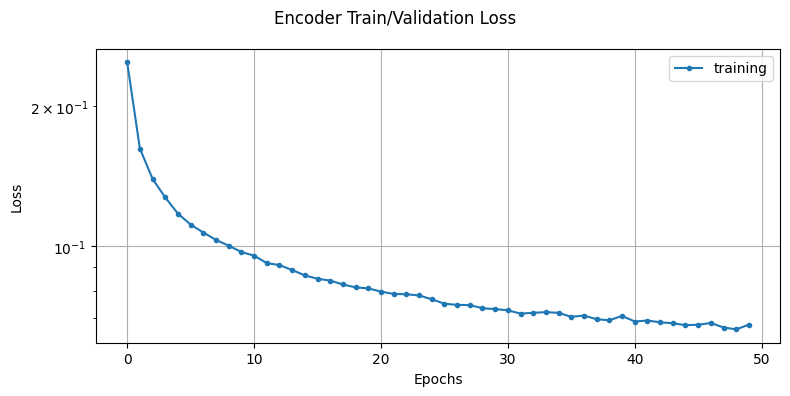

In [29]:
# Plot training and validation loss
from utils import plot_multi_loss
print('\n---- Plotting loss ----\n')
train_loss_l = []
valid_loss_l = []
max_length = np.max([len(v) for v in historyMulti.values()])
for k, v in historyMulti.items():
    if len(v) < max_length:
        v = v + [v[-1]] * (max_length - len(v))
    if 'val' in k:
        valid_loss_l.append(v)
    else:
        train_loss_l.append(v)

train_loss_l = np.mean(train_loss_l, axis=0)
valid_loss_l = np.mean(valid_loss_l, axis=0)
print(train_loss_l)
print(valid_loss_l)

plot_loss({'training': train_loss_l, 'validation': valid_loss_l},
        title='Encoder Train/Validation Loss',
        figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))

plot_multi_loss(historyMulti, title='Encoder loss per output',
        figname=os.path.join(plots_dir, 'encoder_per_output_loss.png'))

In [183]:
feature_cfg = {
    'epochs': 50,
    'dense_layers': [256, 32],
    'activation': 'relu',
    'dropout': 0.0,
    'loss': 'mae',
    'lr': 1e-3,
    'dataset%': 1,
    'use_bias': True,
    'batchnorm': False,
    'batch_size': 128,
}


feature_extractor = FeatureExtractor(input_shape=y_latent_valid.shape[1:],
                                     output_features=7,
                                     **feature_cfg)

feature_extractor.model.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 17)]              0         
                                                                 
 dense_1 (Dense)             (None, 256)               4608      
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dense_final (Dense)         (None, 7)                 231       
                                                                 
Total params: 13,063
Trainable params: 13,063
Non-trainable params: 0
_________________________________________________________________


In [184]:
input_latents = y_latent_valid[0:1]
output_features = feature_extractor.predict(input_latents)
print(input_latents.shape, output_features.shape)

(1, 17) (1, 7)


In [185]:
tf.config.run_functions_eagerly(True)
# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=20, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'feature-extractor.h5'),
                                            monitor='val_loss', save_best_only=True)

start_time = time.time()

history = feature_extractor.model.fit(
    x=y_latent_train, y=y_train[:, 0],
    validation_data=(y_latent_valid, y_valid[:, 0]),
    # x=y_train, y=x_train,
    # validation_data=(y_valid, x_valid),
    epochs=feature_cfg['epochs'],
    callbacks=[stop_early],
    batch_size=feature_cfg['batch_size'],
    verbose=1)

total_time = time.time() - start_time
print(
    f'\n---- Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')

Epoch 1/50
  8/125 [>.............................] - ETA: 1s - loss: 0.4820

/home/kiliakis/install/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


125/125 [==============================] - 2s 13ms/step - loss: 0.2049 - val_loss: 0.0626
Epoch 2/50
125/125 [==============================] - 2s 12ms/step - loss: 0.0360 - val_loss: 0.0299
Epoch 3/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0203 - val_loss: 0.0158
Epoch 4/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0152 - val_loss: 0.0142
Epoch 5/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0128 - val_loss: 0.0122
Epoch 6/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0119 - val_loss: 0.0103
Epoch 7/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0105 - val_loss: 0.0190
Epoch 8/50
125/125 [==============================] - 2s 12ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 9/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 10/50
125/125 [==============================] - 2s 13ms/step - loss: 0.0091 - val_loss: 0.0083


(1403, 7)


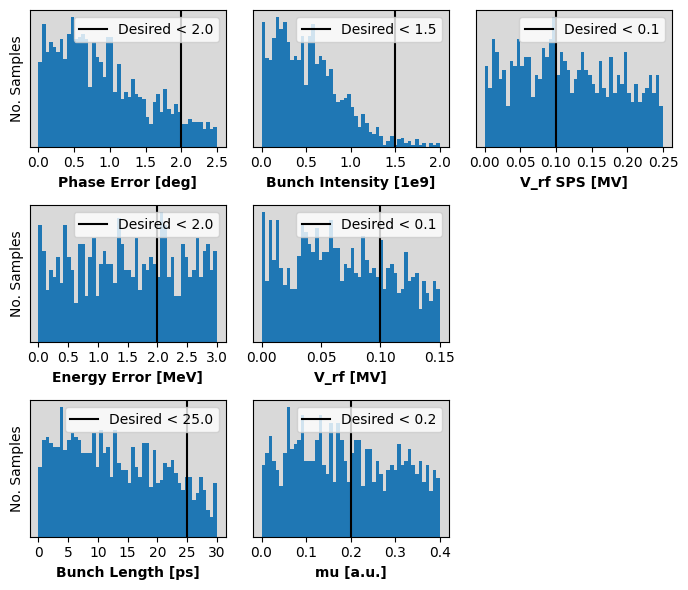

In [176]:
# evaluate the model
import bisect
from utils import unnormalize_params

y_valid_pred = feature_extractor.predict(y_latent_valid)


y_test_unnorm = unnormalize_params(
    y_valid[:, 0], y_valid[:, 1], y_valid[:, 2],
    y_valid[:, 3], y_valid[:, 4], y_valid[:, 5],
    y_valid[:, 6], normalization=train_cfg['normalization'])

y_pred_unnorm = unnormalize_params(
    y_valid_pred[:, 0], y_valid_pred[:, 1], y_valid_pred[:, 2],
    y_valid_pred[:, 3], y_valid_pred[:, 4], y_valid_pred[:, 5],
    y_valid_pred[:, 6], normalization=train_cfg['normalization'])

diffs = np.abs(np.array(y_pred_unnorm).T - np.array(y_test_unnorm).T)
print(diffs.shape)


# Encoder, graphical evaluation

evaluation_config = {
    0: {'xlabel': 'Phase Error [deg]',
        'range': (0, 2.5),
        'xticks': np.arange(0, 2.6, 0.5),
        'desired': 2,
        'multiplier': 1},
    1: {'xlabel': 'Energy Error [MeV]',
        'range': (0, 3.),
        'xticks': np.arange(0, 3.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    2: {'xlabel': 'Bunch Length [ps]',
        'range': (0, 30),
        'xticks': np.arange(0, 30.5, 5),
        'desired': 25,
        'multiplier': 1e12},
    3: {'xlabel': 'Bunch Intensity [1e9]',
        'range': (0, 2),
        'xticks': np.arange(0, 2.1, 0.5),
        'desired': 1.5,
        'multiplier': 1e-9},
    4: {'xlabel': 'V_rf [MV]',
        'range': (0, 0.15),
        'xticks': np.arange(0, 0.16, 0.05),
        'desired': 0.1,
        'multiplier': 1},
    5: {'xlabel': 'mu [a.u.]',
        'range': (0, 0.4),
        'xticks': np.arange(0, 0.41, 0.1),
        'desired': 0.2,
        'multiplier': 1},
    6: {'xlabel': 'V_rf SPS [MV]',
        'range': (0, 0.25),
        'xticks': np.arange(0, 0.26, 0.05),
        'desired': 0.1,
        'multiplier': 1},
}

fig, axes = plt.subplots(ncols=3, nrows=3, sharex=False,
                         sharey=False, figsize=(7, 6))
axes = np.ravel(axes, order='F')

for idx, ax in enumerate(axes):
    if idx == 7:
        break
    plt.sca(ax)
    config = evaluation_config[idx]
    hist, bins, _ = plt.hist(
        diffs[:, idx]*config['multiplier'], bins=50, range=config['range'])
    cumsum = np.cumsum(hist) / diffs.shape[0]
    b = bisect.bisect(cumsum, 0.95)
    # plt.axvline(x=bins[b+1], color='tab:orange',
    #             label=f'95% < {bins[b+1]:.2f}')
    plt.xticks(config['xticks'])
    plt.yticks([], [])
    plt.xlabel(config['xlabel'], fontweight='heavy')
    if idx < 3:
        plt.ylabel('No. Samples')
    plt.axvline(x=config['desired'], color='black',
                label=f'Desired < {config["desired"]:.1f}')
    plt.legend(loc='upper right')
    plt.gca().set_facecolor('0.85')

# delete last
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])

plt.tight_layout()
plt.savefig(f'{plots_dir}/enc-abs-error.png', transparent=True,
            dpi=400, bbox_inches='tight')

In [121]:
y_valid_pred = feature_extractor.predict(y_latent_valid)
tf.reduce_mean(tf.square(y_valid_pred - y_valid), axis=0).shape
# loss = np.mean(np.abs(y_valid_pred - y_valid), axis=0)
# print(loss)

# print(y_valid_pred.shape)
# loss = keras.losses.mean_absolute_error(y_valid, y_valid_pred)
# print(loss)

TensorShape([7])

In [82]:
%matplotlib inline

# Plot training and validation loss
print('\n---- Plotting loss ----\n')

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
            title='Encoder Train/Validation Loss',
            figname=os.path.join(plots_dir, 'autoenc-noib_loss.png'))


---- Plotting loss ----



In [81]:
# save the model
autoenc.save(os.path.join(weights_dir, 'autoenc-transpose-noib.h5'))

In [85]:
def plot_sample(samples, autoenc, figname=None):

    ncols = len(samples)
    # Get nrows * nrows random images
    # sample = np.random.choice(np.arange(len(x_train)),
    #                         size=ncols, replace=False)

    samples_X = tf.gather(x_train, samples)
    pred_samples_X = autoenc.predict(samples_X)
    # samples_y = tf.gather(y_train, sample)

    # Create 3x3 grid of figures
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(14, 7))
    # axes = np.ravel(axes)
    for i in range(ncols):
        sample_X = samples_X[i, 14:-14, 14:-14]
        pred_sample_X = pred_samples_X[i, 14:-14, 14:-14]
        ax = axes[0, i]
        ax.set_xticks([])
        ax.set_yticks([])
        # show the image
        ax.imshow(sample_X, cmap='jet')
        # Set the label
        ax.set_title(f'Real')

        ax = axes[1, i]
        ax.set_xticks([])
        ax.set_yticks([])
        # show the image
        ax.imshow(pred_sample_X, cmap='jet')
        # Set the label
        ax.set_title(
            f'Pred, MAE: {np.mean(np.abs(sample_X - pred_sample_X)):.2e}')
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
    else:
        plt.show()
    plt.close()

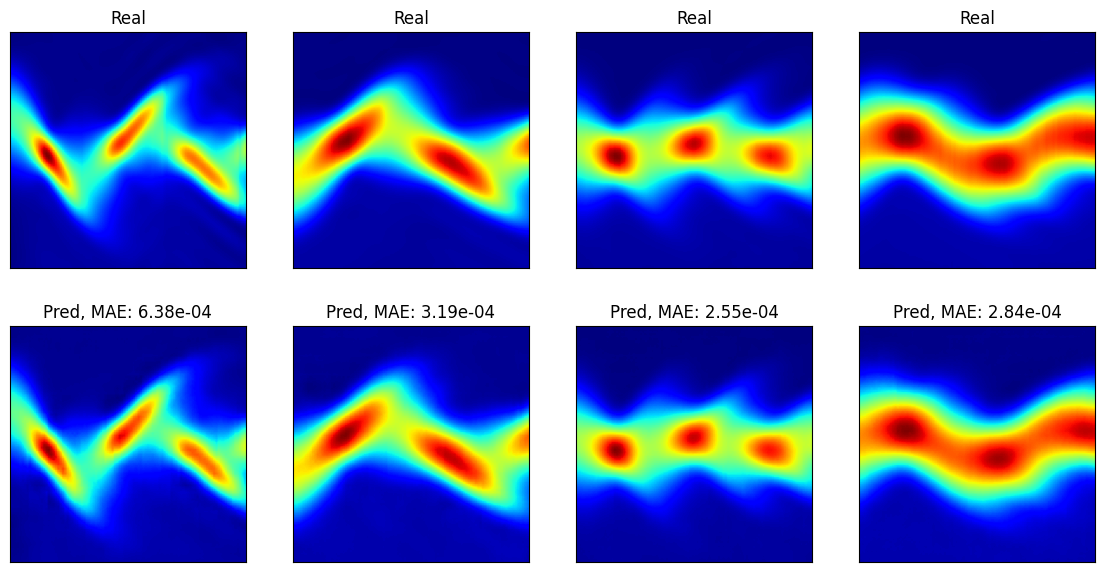

In [86]:
plot_sample([0,1,2,3], autoenc)

In [66]:
def calculate_padding(input_shape, target_shape):
    # Calculate the padding needed for the first two dimensions
    padding_first_dim = (target_shape[0] - input_shape[0]) // 2
    mod_first_dim = (target_shape[0] - input_shape[0]) % 2
    padding_second_dim = (target_shape[1] - input_shape[1]) // 2
    mod_second_dim = (target_shape[1] - input_shape[1]) % 2

    # If the padding doesn't divide evenly, add the extra padding to one side
    pad_first_dim_left = padding_first_dim + mod_first_dim
    pad_second_dim_left = padding_second_dim + mod_second_dim

    # Create the padding configuration for np.pad
    padding_config = (
        # Padding for the first dimension
        (pad_first_dim_left, padding_first_dim),
        # Padding for the second dimension
        (pad_second_dim_left, padding_second_dim),
        # (0, 0)  # Padding for the third dimension
    )

    return padding_config


# model definition
class AutoEncoderTransposeIB(keras.Model):
    # Pooling can be None, or 'Average' or 'Max'
    def __init__(self, output_name='autoencoder',
                 input_shape=(128, 128, 1), dense_layers=[7],
                 decoder_dense_layers=[],
                 cropping=[[0, 0], [0, 0]],
                 filters=[8, 16, 32],  kernel_size=3, conv_padding='same',
                 strides=[2, 2], activation='relu',
                 final_activation='linear', final_kernel_size=3,
                 pooling=None, pooling_size=[2, 2],
                 pooling_strides=[1, 1], pooling_padding='valid',
                 dropout=0.0, learning_rate=0.001, loss='mse',
                 metrics=[], use_bias=True, conv_batchnorm=False,
                 dense_batchnorm=False, data_type='float32',
                 **kwargs):
        super().__init__()

        self.output_name = output_name
        self.inputShape = input_shape
        # img_input = 
        # the kernel_size can be a single int or a list of ints
        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * len(filters)
        assert len(kernel_size) == len(filters)

        # the strides can be a list of two ints, or a list of two-int lists
        if isinstance(strides[0], int):
            strides = [strides for _ in filters]
        assert len(strides) == len(filters)

        # set the input size
        img_input = keras.Input(shape=input_shape, name='Input', dtype=data_type)
        scalar_input = keras.Input(shape=(1,), name='Scalar_input')
        # this is the autoencoder case
        # crop the edges
        cropped = keras.layers.Cropping2D(
            cropping=cropping, name='Crop')(img_input)
        x = cropped

        # For evey Convolutional layer
        for i, f in enumerate(filters):
            # Add the Convolution
            x = keras.layers.Conv2D(
                filters=f, kernel_size=kernel_size[i], strides=strides[i],
                use_bias=use_bias, padding=conv_padding,
                name=f'CNN_{i+1}')(x)

            # Apply batchnormalization
            if conv_batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)

            # Apply the activation function
            x = keras.activations.get(activation)(x)

            # Optional pooling after the convolution
            if pooling == 'Max':
                x = keras.layers.MaxPooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'MaxPooling_{i+1}')(x)
            elif pooling == 'Average':
                x = keras.layers.AveragePooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'AveragePooling_{i+1}')(x)

        # we have reached the latent space
        last_shape = x.shape[1:]
        x = keras.layers.Flatten(name='Flatten')(x)
        flat_shape = x.shape[1:]
        # Now we add the dense layers
        for i, units in enumerate(dense_layers):
            # Add the layer
            x = keras.layers.Dense(units=units, activation=activation,
                                   name=f'encoder_dense_{i+1}')(x)

            # Apply batchnormalization
            if dense_batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)

            # Add dropout optionally
            if dropout > 0 and dropout < 1:
                x = keras.layers.Dropout(dropout, name=f'dropout_{i+1}')(x)

        # append the intensity to x
        x = keras.layers.Concatenate(
            axis=-1, name='Concatenate')([x, scalar_input])

        # a dummy layer just to name it latent space
        x = keras.layers.Lambda(lambda x: x, name='LatentSpace')(x)

        # Now we add the decoder dense layers
        for i, units in enumerate(decoder_dense_layers):
            # Add the layer
            x = keras.layers.Dense(units=units, activation=activation,
                                   name=f'decoder_dense_{i+1}')(x)

            # Apply batchnormalization
            if dense_batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)

            # Add dropout optionally
            if dropout > 0 and dropout < 1:
                x = keras.layers.Dropout(dropout, name=f'dropout_{i+1}')(x)

        # Now reshape back to last_shape
        x = keras.layers.Dense(units=np.prod(flat_shape), activation=activation,
                               name='decoder_dense_final')(x)

        x = keras.layers.Reshape(target_shape=last_shape, name='Reshape')(x)
        # Now with transpose convolutions we go back to the original size

        for i, f in enumerate(filters[::-1]):
            x = keras.layers.Conv2DTranspose(
                filters=f, kernel_size=kernel_size[-i -
                                                   1], strides=strides[-i-1],
                use_bias=use_bias, padding=conv_padding,
                name=f'CNN_Transpose_{i+1}')(x)

        # final convolution to get the right number of channels
        x = keras.layers.Conv2DTranspose(filters=1, kernel_size=final_kernel_size,
                                         strides=1, use_bias=use_bias, padding='same',
                                         name=f'CNN_Transpose_Final')(x)

        x = keras.layers.Activation(activation=final_activation,
                                    name='final_activation')(x)
        before_padding = x
        # Add zero padding
        padding = calculate_padding(
            input_shape=before_padding.shape[1:], target_shape=input_shape)
        outputs = keras.layers.ZeroPadding2D(
            padding=padding, name='Padding')(x)

        model = keras.Model(inputs=[img_input, scalar_input], outputs=outputs, name=output_name)

        # assert model.layers[-1].output_shape[1:] == input_shape

        # Also initialize the optimizer and compile the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        self.model = model

    def predict(self, wf_in):
        wf_out = self.model(wf_in)
        return wf_out

    def load(self, weights_file):
        self.model = keras.models.load_model(weights_file)

    def save(self, weights_file):
        self.model.save(weights_file)

In [68]:
# Train specific
train_cfg = {
    'epochs': 5,
    'filters': [8, 16, 32],
    'dense_layers': [512, 16],
    'decoder_dense_layers': [512],
    'cropping': [14, 14],
    'kernel_size': 3,
    'strides': [2, 2],
    'activation': 'relu',
    'conv_padding': 'same',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.0,
    'loss': 'mae',
    'lr': 1e-3,
    'dataset%': 1,
    'use_bias': True,
    'normalization': 'minmax',
    'img_normalize': 'off',
    'conv_batchnorm': False,
    'dense_batchnorm': False,
    'batch_size': 128,
    'data_type': 'float16'
}

# Model instantiation
start_t = time.time()

autoenc = AutoEncoderTransposeIB(input_shape=x_train.shape[1:], **train_cfg)
print(autoenc.model.summary())

print(
    f'\n---- Models have been initialized, elapsed: {time.time() - start_t} ----\n')

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 Crop (Cropping2D)              (None, 100, 100, 1)  0           ['Input[0][0]']                  
                                                                                                  
 CNN_1 (Conv2D)                 (None, 50, 50, 8)    80          ['Crop[0][0]']                   
                                                                                                  
 tf.nn.relu_24 (TFOpLambda)     (None, 50, 50, 8)    0           ['CNN_1[0][0]']        

In [71]:
input_wf = x_train[0:1]
# print(y_train.shape)
input_inten = y_train[0:1, 3]
output_wf = autoenc.predict([input_wf, input_inten])
print(input_wf.shape, output_wf.shape)

(15885, 7)
(1, 128, 128, 1) (1, 128, 128, 1)


In [38]:
# model definition
class AutoEncoderReshape(keras.Model):
    # Pooling can be None, or 'Average' or 'Max'
    def __init__(self, output_name='autoencoder',
                 input_shape=(128, 128, 1), dense_layers=[1024, 256],
                 dense_layers_decode=[1024],
                 cropping=[[0, 0], [0, 0]],
                 filters=[8, 16, 32],  kernel_size=3, conv_padding='same',
                 strides=[2, 2], activation='relu',
                 pooling=None, pooling_size=[2, 2],
                 pooling_strides=[1, 1], pooling_padding='valid',
                 dropout=0.0, learning_rate=0.001, loss='mse',
                 metrics=[], use_bias=True, batchnorm=False,
                 **kwargs):
        super().__init__()

        self.output_name = output_name
        self.inputShape = input_shape
        # the kernel_size can be a single int or a list of ints
        if isinstance(kernel_size, int):
            kernel_size = [kernel_size] * len(filters)
        assert len(kernel_size) == len(filters)

        # the strides can be a list of two ints, or a list of two-int lists
        if isinstance(strides[0], int):
            strides = [strides for _ in filters]
        assert len(strides) == len(filters)

        # set the input size
        inputs = keras.Input(shape=input_shape, name='Input', dtype='float32')
        # this is the autoencoder case
        # crop the edges
        cropped = keras.layers.Cropping2D(
            cropping=cropping, name='Crop')(inputs)
        x = cropped
        cropped_shape = x.shape[1:]

        # For evey Convolutional layer
        for i, f in enumerate(filters):
            # Add the Convolution
            x = keras.layers.Conv2D(
                filters=f, kernel_size=kernel_size[i], strides=strides[i],
                use_bias=use_bias, padding=conv_padding,
                name=f'CNN_{i+1}')(x)

            # Apply batchnormalization
            # if batchnorm:
            #     x = tf.keras.layers.BatchNormalization()(x)

            # Apply the activation function
            x = keras.activations.get(activation)(x)

            # Optional pooling after the convolution
            if pooling == 'Max':
                x = keras.layers.MaxPooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'MaxPooling_{i+1}')(x)
            elif pooling == 'Average':
                x = keras.layers.AveragePooling2D(
                    pool_size=pooling_size, strides=pooling_strides,
                    padding=pooling_padding, name=f'AveragePooling_{i+1}')(x)

        # we have reached the latent space
        # last_shape = x.shape[1:]
        x = keras.layers.Flatten(name='Flatten')(x)

        # flat_shape = x.shape[1:]
        # Now we add the dense layers
        for i, units in enumerate(dense_layers):
            # Add the layer
            x = keras.layers.Dense(units=units, activation=activation,
                                   name=f'dense_{i+1}')(x)

            # Apply batchnormalization
            if batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)

            # Add dropout optionally
            if dropout > 0 and dropout < 1:
                x = keras.layers.Dropout(dropout, name=f'dropout_{i+1}')(x)


        # Then some more dense layers
        for i, units in enumerate(dense_layers_decode):
            # Add the layer
            x = keras.layers.Dense(units=units, activation=activation,
                                   name=f'dense_decode_{i+1}')(x)

            # Apply batchnormalization
            if batchnorm:
                x = tf.keras.layers.BatchNormalization()(x)

            # Add dropout optionally
            if dropout > 0 and dropout < 1:
                x = keras.layers.Dropout(
                    dropout, name=f'dropout_decode_{i+1}')(x)

        # add the last dense layer
        x = keras.layers.Dense(units=np.prod(cropped_shape), activation=activation,
                               name='dense_final')(x)

        x = keras.layers.Reshape(
            target_shape=cropped_shape, name='Reshape')(x)
        # decoder = keras.Model(inputs=inputs, outputs=x, name='decoder')

        # Add padding
        outputs = keras.layers.ZeroPadding2D(
            padding=cropping, name='ZeroPadding')(x)

        # Now with transpose convolutions we go back to the original size

        model = keras.Model(inputs=inputs, outputs=outputs)

        # assert model.layers[-1].output_shape[1:] == input_shape

        # Also initialize the optimizer and compile the model
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        self.model = model

    def predict(self, wf_in):
        wf_out = self.model(wf_in)
        return wf_out

    def load(self, weights_file):
        self.model = keras.models.load_model(weights_file)

    def save(self, weights_file):
        self.model.save(weights_file)

In [46]:
# Train specific
train_cfg = {
    'epochs': 50,
    'filters': [8, 16, 32],
    'dense_layers': [512, 256],
    'dense_layers_decode': [256, 512],
    'cropping': [14, 14],
    'kernel_size': 3,
    'strides': [2, 2],
    'activation': 'relu',
    'conv_padding': 'same',
    'pooling': None,
    'pooling_size': [0, 0],
    'pooling_strides': [1, 1],
    'pooling_padding': 'valid',
    'dropout': 0.0,
    'loss': 'mse',
    'lr': 1e-3,
    'dataset%': 1,
    'use_bias': True,
    'normalization': 'minmax',
    'img_normalize': 'off',
    'batchnorm': False,
    'batch_size': 128
}

# Model instantiation
start_t = time.time()

autoenc2 = AutoEncoderReshape(input_shape=x_train.shape[1:], **train_cfg)
print(autoenc2.model.summary())

print(
    f'\n---- Models have been initialized, elapsed: {time.time() - start_t} ----\n')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 Crop (Cropping2D)           (None, 100, 100, 1)       0         
                                                                 
 CNN_1 (Conv2D)              (None, 50, 50, 8)         80        
                                                                 
 tf.nn.relu_24 (TFOpLambda)  (None, 50, 50, 8)         0         
                                                                 
 CNN_2 (Conv2D)              (None, 25, 25, 16)        1168      
                                                                 
 tf.nn.relu_25 (TFOpLambda)  (None, 25, 25, 16)        0         
                                                                 
 CNN_3 (Conv2D)              (None, 13, 13, 32)        4640

In [47]:
input_wf = x_train[0:1]
output_wf = autoenc2.predict(input_wf)
print(input_wf.shape, output_wf.shape)

(1, 128, 128, 1) (1, 128, 128, 1)


In [48]:
tf.config.run_functions_eagerly(True)
# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=20, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder.h5'),
                                            monitor='val_loss', save_best_only=True)

start_time = time.time()

history = autoenc2.model.fit(
    x=x_train, y=x_train,
    validation_data=(x_valid, x_valid),
    # x=y_train, y=x_train,
    # validation_data=(y_valid, x_valid),
    epochs=train_cfg['epochs'],
    callbacks=[stop_early],
    batch_size=train_cfg['batch_size'],
    verbose=1)

total_time = time.time() - start_time
print(
    f'\n---- Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')

Epoch 1/50


/home/kiliakis/install/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


13/13 [==============================] - 2s 146ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 2/50
13/13 [==============================] - 2s 147ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 3/50
13/13 [==============================] - 2s 153ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 4/50
13/13 [==============================] - 2s 162ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/50
13/13 [==============================] - 2s 147ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/50
13/13 [==============================] - 2s 148ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/50
13/13 [==============================] - 2s 145ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/50
13/13 [==============================] - 2s 146ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/50
13/13 [==============================] - 2s 150ms/step - loss: 0.0010 - val_loss: 8.4926e-04
Epoch 10/50
13/13 [==============================] - 2s 145ms/step - loss: 8.1673e-04 - val_loss: 7.4596e-0


---- Plotting loss ----



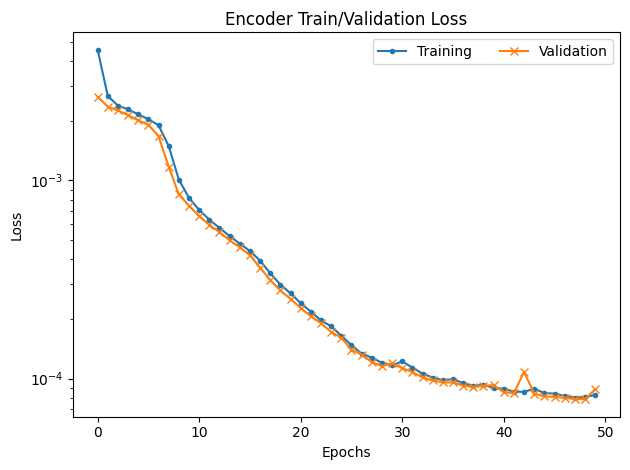

In [49]:
%matplotlib inline

# Plot training and validation loss
print('\n---- Plotting loss ----\n')

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
            title='Encoder Train/Validation Loss')
            # figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))

In [50]:
# save the model
autoenc2.save(os.path.join(weights_dir, 'autoenc-reshape.h5'))


In [ ]:
config_dict = {}
config_dict['model'] = train_cfg.copy()

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=20, restore_best_weights=True)
# save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'encoder.h5'),
#                                             monitor='val_loss', save_best_only=True)

for dense_units in [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]:
# for dense_units in [1, 2]:

    train_cfg['dense_layers'] = [dense_units]
    autoenc = AutoEncoder(**train_cfg)

    print("----- Model Initialized, training with dense units: ", dense_units)
    start_time = time.time()

    history = autoenc.model.fit(
        x=x_train, y=x_train, 
        epochs=train_cfg['epochs'],
        validation_data=(x_valid, x_valid),
        callbacks=[stop_early], 
        batch_size=train_cfg['batch_size'],
        verbose=0)

    total_time = time.time() - start_time
    print(
            f'\n---- {dense_units}: Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')

    # Plot training and validation loss
    print('\n---- Plotting loss ----\n')

    train_loss_l = np.array(history.history['loss'])
    valid_loss_l = np.array(history.history['val_loss'])

    plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
                title='Encoder Train/Validation Loss',
                figname=os.path.join(plots_dir, f'units{dense_units}_train_valid_loss.png'))

    # Plot some samples
    plot_sample([0, 1, 2, 3], autoenc,
                figname=os.path.join(plots_dir, f'units{dense_units}_samples.png'))

    # save file with experiment configuration
    config_dict[f'{dense_units}'] = {
        'epochs': len(history.history["loss"]),
        'min_train_loss': float(np.min(train_loss_l)),
        'min_valid_loss': float(np.min(valid_loss_l)),
        'total_train_time': total_time,
        'used_gpus': len(gpus)
    }

# save config_dict
with open(os.path.join(trial_dir, 'autoencoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)




---- Plotting loss ----



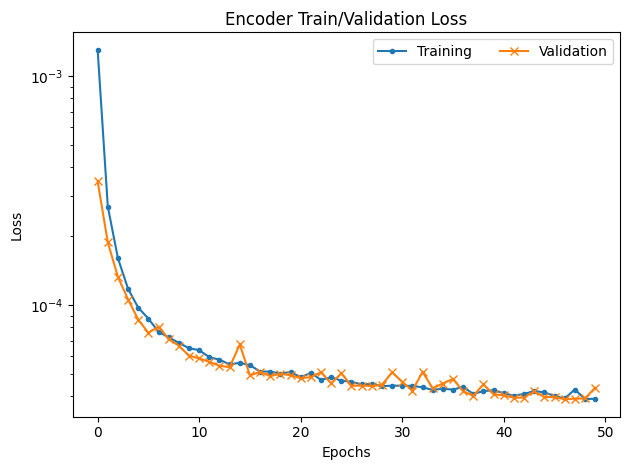

In [68]:
%matplotlib inline

# Plot training and validation loss
print('\n---- Plotting loss ----\n')

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
            title='Encoder Train/Validation Loss')
            # figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))

In [ ]:
ncols = 4
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=ncols, replace=False)

samples_X = tf.gather(x_train, sample)
pred_samples_X = autoenc.predict(samples_X)
# samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(14, 7))
# axes = np.ravel(axes)
for i in range(ncols):
    ax = axes[0, i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    ax.set_title(f'Real')

    ax = axes[1, i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(pred_samples_X[i], cmap='jet')
    # Set the label
    ax.set_title(f'Pred, MSE: {np.mean((samples_X[i] - pred_samples_X[i])**2):.2e}')

In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = train_cfg.copy()
config_dict['encoder'].update({
    'epochs': len(history.history["loss"]),
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': len(gpus)
})

# save config_dict
with open(os.path.join(trial_dir, 'encoder-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)


The following is used to plot the performance of the models with increasingly larger parameter space. 

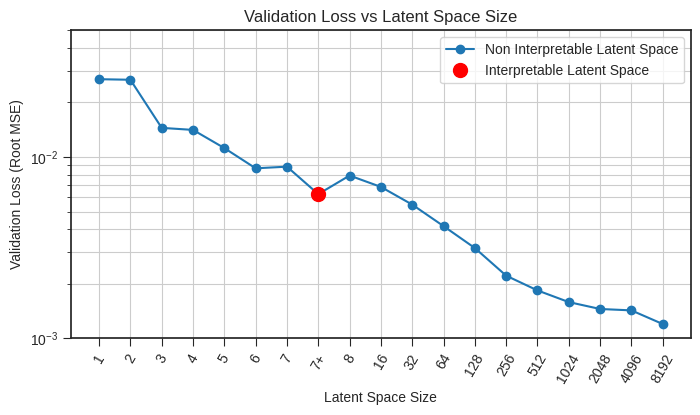

In [23]:
# read the yml config file
plt.style.use('seaborn-v0_8-ticks')

file_name = os.path.join('trials/best_AE', 'autoencoder-summary.yml')
with open(file_name, 'r') as configfile:
    config_dict = yaml.load(configfile, Loader=yaml.FullLoader)


# get the keys and times
x_val = []
y_val = []
for key, val in config_dict.items():
    if (key not in ['model', 'timestamp']):
        if '-' in key:
            x_val.append(int(key.split('-')[0]) + 0.5)
        else: 
            x_val.append(int(key))
        # if (isinstance(key, int)):
        #     x_val.append(key)
        # else:
        y_val.append(val['min_valid_loss'])

# sort the values based on the keys
x_val = np.array(x_val)
y_val = np.array(y_val)
idx = np.argsort(x_val)
x_val = x_val[idx]
y_val = y_val[idx]

# plot the values in a log y scale
fig, ax = plt.subplots(figsize=(8, 4))
# add grid
ax.grid(which='both', axis='both')
# add y axis minor tick labels
# ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1])

xticks = np.arange(len(x_val))

ax.semilogy(xticks, np.sqrt(y_val), 'o-', label='Non Interpretable Latent Space')
# get index of 7.5
idx = np.where(x_val == 7.5)[0][0]
ax.semilogy(xticks[idx], np.sqrt(y_val[idx]), 'ro', markersize=10, label='Interpretable Latent Space')
# annotate the points with the y values
# for i, (x, y) in enumerate(zip(xticks, y_val)):
#     ax.annotate(f'{y:.1e}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

x_val = [int(x) if x!= 7.5 else '7+' for x in x_val]

ax.set_xticks(xticks, x_val, rotation=60)
plt.legend(frameon=True, loc='upper right', fancybox=True, framealpha=0.8)
# set the y-axis limits from 10-6 to 10-3
# ax.set_ylim([1e-6, 1e-3])
ax.set_ylim([1e-3, 0.5e-1])

ax.set_xlabel('Latent Space Size')
ax.set_ylabel('Validation Loss (Root MSE)')
ax.set_title('Validation Loss vs Latent Space Size')
plt.savefig('trials/best_AE/encoder_loss_vs_dense_units.png', dpi=300, bbox_inches='tight')